In [1]:
%matplotlib inline

In [2]:
%precision 3

'%.3f'

In [3]:
%load_ext rpy2.ipython

In [4]:
from scipy.stats import chi2, norm

In [5]:
from IPython.display import Markdown

In [7]:
import statsmodels.stats.diagnostic as smsdia
import statsmodels.stats.outliers_influence as oi
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.stats as sms
from statsmodels.tsa.api import VARMAX, VAR
from statsmodels.tsa.stattools import adfuller

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [173]:
sns.set(style='ticks', palette='Set2')

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Caso 2.3 PRESENTAR

_Estudio de las __relaciones__ entre los __PIB__ de varios países entre sí. Identificación de países dominantes y países seguidores._

_En este ejercicio se trata de estimar un __modelo multiecuacional__ en el que se analizan las relaciones entre el __crecimiento del PIB__ de tres países cualquiera extraídos de alguna base de datos (Ministerio de Economía, Banco de España, INE, etc.). _

_Una vez tengamos los datos __(preferiblemente trimestrales)__ del PIB a __precios constantes__, tendremos que calcular la __tasa de crecimiento anual__ para cada país y luego estimaremos un __modelo VAR sin restricciones__, Se trata de ver si algún país de los seleccionados actúa como líder y si el resto de países actúan como seguidores._

[⬆Caso2.3](#Caso-2.3-PRESENTAR)	[⬆a](#a)		[⬆b](#b)		[⬆c](#c)		

## DATOS
- Nombre: Chain GDP (millons euros)
- Fuente: EUROSTAT
- Enlace: http://ec.europa.eu/eurostat/web/national-accounts/data/database

In [10]:
data = pd.read_csv('eu_gdp_q.csv', index_col=0, parse_dates=True)

In [11]:
for i,e in enumerate(data.GEO.unique()):
    print(i,e)

0 European Union (28 countries)
1 European Union (15 countries)
2 Euro area (EA11-2000, EA12-2006, EA13-2007, EA15-2008, EA16-2010, EA17-2013, EA18-2014, EA19)
3 Euro area (19 countries)
4 Euro area (18 countries)
5 Euro area (12 countries)
6 Belgium
7 Bulgaria
8 Czech Republic
9 Denmark
10 Germany (until 1990 former territory of the FRG)
11 Estonia
12 Ireland
13 Greece
14 Spain
15 France
16 Croatia
17 Italy
18 Cyprus
19 Latvia
20 Lithuania
21 Luxembourg
22 Hungary
23 Malta
24 Netherlands
25 Austria
26 Poland
27 Portugal
28 Romania
29 Slovenia
30 Slovakia
31 Finland
32 Sweden
33 United Kingdom
34 Iceland
35 Norway
36 Switzerland
37 Former Yugoslav Republic of Macedonia, the
38 Albania
39 Serbia


In [12]:
index_paises = [10, 14, 33]

In [13]:
paises = data.GEO.unique()[index_paises]

In [14]:
d = dict()
for p in paises:
    d[p] = data[data.GEO == p].Value

In [15]:
pib = pd.DataFrame.from_dict(d)

In [16]:
pib.columns = ['germany', 'spain', 'uk']

# VALORES PERDIDOS

In [17]:
pib.replace(to_replace=':', value=np.nan, inplace=True)

In [18]:
pib.head()

,germany,spain,uk
TIME,,,
1975-01-01,NaN,NaN,206 522.0
1975-04-01,NaN,NaN,202 980.6
1975-07-01,NaN,NaN,202 336.9
1975-10-01,NaN,NaN,204 823.2
1976-01-01,NaN,NaN,208 175.8


In [19]:
pib = pib.dropna()
pib = pib.applymap(lambda x: x.replace(' ', ''))
pib = pib.astype('float')
pib.head()

,germany,spain,uk
TIME,,,
1995-01-01,532282.4,175965,327356.5
1995-04-01,536668.6,177181,328610.3
1995-07-01,538410.2,178027,332094.4
1995-10-01,538152.2,179278,333514.5
1996-01-01,533089.0,180436,337196.3


In [20]:
pib.tail()

,germany,spain,uk
TIME,,,
2014-07-01,684570.6,260281,493645.2
2014-10-01,688763.3,262050,497349.5
2015-01-01,691149.9,264331,499176.3
2015-04-01,694181.5,266942,502436.8
2015-07-01,696374.6,269039,504777.1


In [21]:
len(pib)

83

In [22]:
lpib = np.log(pib).copy()

# ANÁLISIS UNIVARIANTE

## TENDENCIA

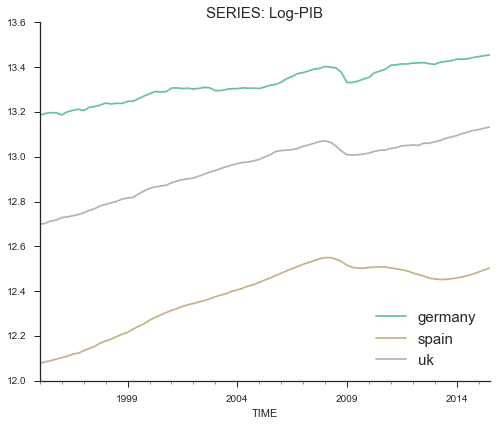

In [169]:
kws_sp = {'subplots':False, 'layout':(3,1), 'figsize':(7,6), 'cmap':'Set2'}
titles = [c.upper() for c in pib.columns]
g = lpib.plot(**kws_sp, sharey=True)
plt.legend(loc=0, fontsize=15)

sns.despine()
plt.title('SERIES: Log-PIB', fontsize=15)
plt.tight_layout()

Del gráfico podemos ver que las series __no son estacionarias__, puesto que tienen tendencia __determinista__ y probablemente __ruptura estructural__ en 2008 (comprar con el test de chow). 

Sin embargo faltaría comprobar si las series tienen tendencia estocástica, mediante el correlograma y el contraste de Dickey-Fuller.

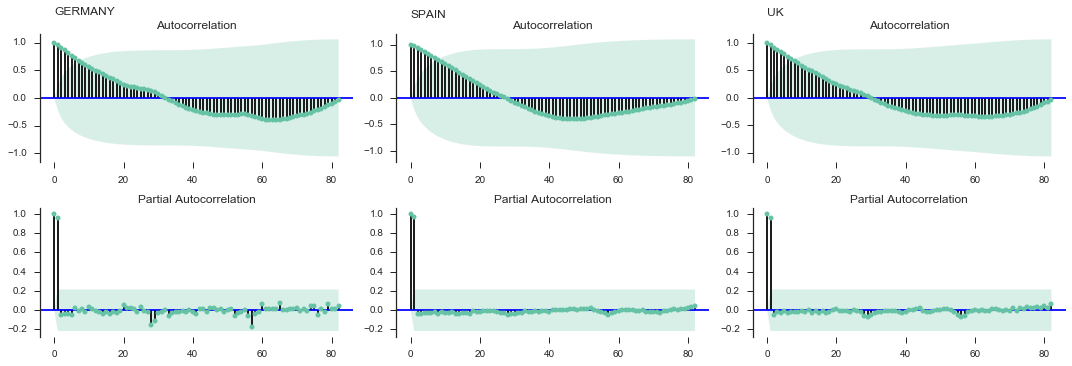

In [174]:
fig, axs = plt.subplots(2,3)
for i, pais in enumerate(lpib.columns):
    plot_acf(lpib[pais], axs[0][i])
    plot_pacf(lpib[pais], axs[1][i])
    axs[0][i].text(x=0,y=1.5,s=pais.upper(), fontsize=12)

fig.set_figheight(5)
fig.set_figwidth(15)
sns.despine(bottom=True)
plt.tight_layout()

El correlograma de la serie nos da pistas sobre la tendencia estocástica, vemos que hay un aplanamiento de la función de autocorrelación propio de las series con tendencia estocástica pero lo comprabamos con la prueba de reíz unitaria.

In [25]:
txt = '## CONTRASTE DICKEY FULLER\n'
txt += '### SERIE: Log-PIB CON CONSTANTE Y TENDENCIA\n'
txt += '$H_0$: $y_{it} \sim I(1)$\n\n'
txt += '$H_a$: $y_{it} \sim I(0)$\n\n'
txt += '|Pais|ADF|pvalue|\n'
txt += '|:---:|:---:|:---:|\n'
for pais in pib.columns:
    d = lpib
    txt += '|%s|%.3f |%.3f\n' % (pais.upper(), 
                                              *adfuller(d[pais], autolag='bic', regression='ct')[:2])
Markdown(txt)

## CONTRASTE DICKEY FULLER
### SERIE: Log-PIB CON CONSTANTE Y TENDENCIA
$H_0$: $y_{it} \sim I(1)$

$H_a$: $y_{it} \sim I(0)$

|Pais|ADF|pvalue|
|:---:|:---:|:---:|
|GERMANY|-3.177 |0.089
|SPAIN|-2.232 |0.472
|UK|-1.968 |0.619


El contraste de Dickey Fuller no rechaza que las series sean integradas de orden 1 para un nivel de significación del 5%, por tanto las series son al menos I(1). El siguiente paso es diferencia las variables una vez y volver a aplicar el contraste.

### PRIMERA DIFERENCIA DEL Log-PIB (Interanual, 4 periodos)

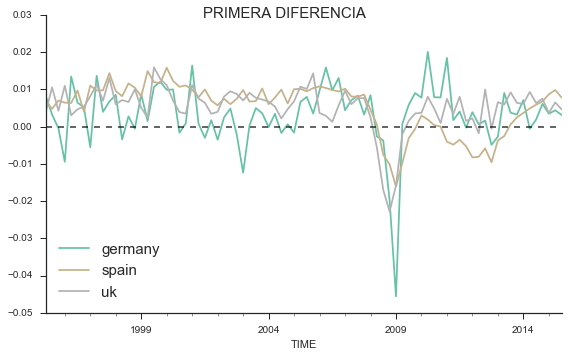

In [26]:
kws = {'figsize':(8,5), 'cmap':'Set2'}

dlpib = lpib.diff(periods=1).dropna()

g = dlpib.plot(**kws)
sns.despine()
plt.axhline(y=0, linewidth=2, linestyle='--', color='black', alpha=0.6)
plt.suptitle('PRIMERA DIFERENCIA', fontsize=15)
plt.legend(loc=0, fontsize=15)
plt.tight_layout()

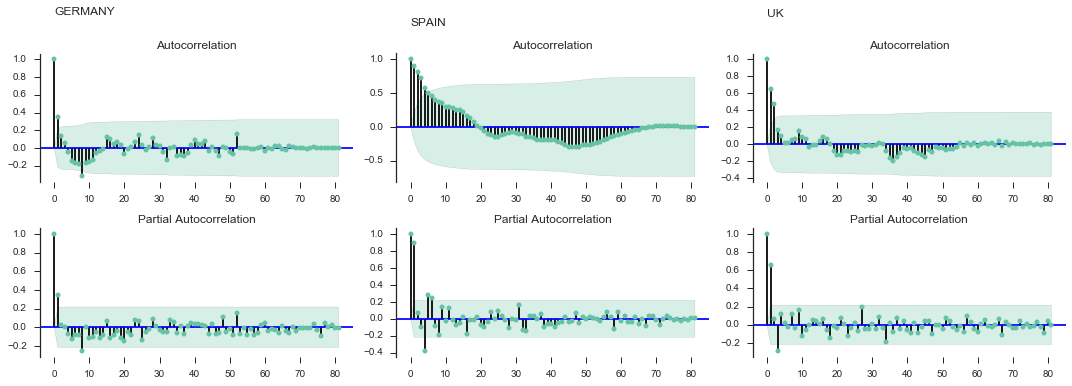

In [27]:
fig, axs = plt.subplots(2,3)

for i, pais in enumerate(pib.columns):
    plot_acf(dlpib[pais], axs[0][i])
    plot_pacf(dlpib[pais], axs[1][i])
    axs[0][i].text(x=0,y=1.5,s=pais.upper(), fontsize=12)

fig.set_figheight(5)
fig.set_figwidth(15)
sns.despine(bottom=True)
plt.tight_layout()

En este caso, las funciones de autocorrelación de las primeras diferencias muestran que para el caso de Alemania y Reino Unido, un correlograma parecido a una caminata aleatoria. Sin embargo para el caso de España, aun persiste ese lento aplanamiento de la FAC, que comentabamos antes, por lo que parece que para este último caso aún no es I(0).

In [28]:
txt = '## CONTRASTE DICKEY FULLER\n'
txt += '### SERIE: dLog-PIB CON CONSTANTE\n'
txt += '$H_0$: $\Delta y_{it} \sim I(1)$\n\n'
txt += '$H_a$: $\Delta y_{it} \sim I(0)$\n\n'
txt += '|Pais|ADF|pvalue|\n'
txt += '|:---:|:---:|:---:|\n'

for pais in pib.columns:
    d = dlpib
    txt += '|%s|%.3f |%.3f\n' % (pais.upper(), *adfuller(d[pais], autolag='bic', regression='c')[:2])

Markdown(txt)

## CONTRASTE DICKEY FULLER
### SERIE: dLog-PIB CON CONSTANTE
$H_0$: $\Delta y_{it} \sim I(1)$

$H_a$: $\Delta y_{it} \sim I(0)$

|Pais|ADF|pvalue|
|:---:|:---:|:---:|
|GERMANY|-6.184 |0.000
|SPAIN|-1.478 |0.544
|UK|-4.049 |0.001


El contraste de raíz unitaria nos da evidencia en contra de la hipótesis nula para Alemania y Reino Unido, encambio no se rechaza para España, por tanto las series en primeras diferencias son I(0) excepto para España que es al menos I(2).

Por tanto a modo de resúmen, las series originales no son estacionarias, tienen tendencia determinista y estocástica. Existe sospecha de ruptura estructural que habrá que comprobar para un correcto análisis. Dado que las series para el caso de Alemania y Reino Unido tienen el mismo orden de integración cabe la posibilidad de que estén cointegradas y esto requiere un tratamiento distinto del propuesto en este ejercicio, por tanto dado que el caso de España no se puede dar cointegración continuamos sin hacer el análisis apropiado.

Dado que para estimar el modelo VAR es necesario que las series sean integradas, necesitamos hallar el orden de integración de la serie para España.

In [29]:
dlpib_spa = dlpib.spain
ddlpib_spa = dlpib_spa.diff(periods=1).dropna()

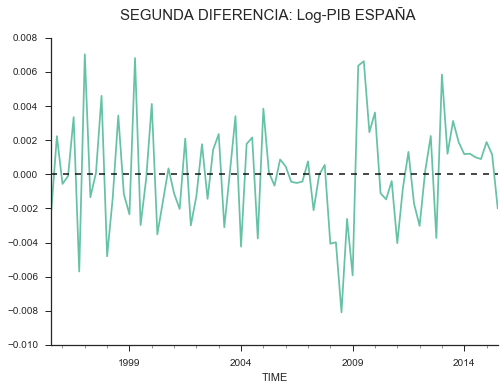

In [30]:
ddlpib_spa.plot()
sns.despine()
plt.axhline(y=0, linestyle='--', linewidth=2, alpha=0.7, color='black')

plt.suptitle('SEGUNDA DIFERENCIA: Log-PIB ESPAÑA', fontsize=15)

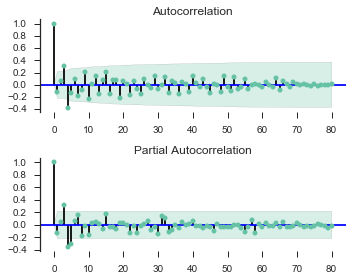

In [31]:
fig, axs = plt.subplots(2,1)
ax1, ax2 = axs
_ = plot_acf(ddlpib_spa, ax=ax1)
_ = plot_pacf(ddlpib_spa, ax=ax2)
sns.despine(bottom=True)
fig.set_figheight(4)
fig.set_figwidth(5)
plt.tight_layout()

El correlograma de las segundas diferencias muestra un correlograma próximo a un ruido blanco. Lo comprobamos con el contraste de Dickey-Fuller.

In [32]:
txt = '## CONTRASTE DICKEY FULLER\n'
txt += '### SERIE: PIB\n'
txt += '$H_0$: $\Delta^2y_{it} \sim I(1)$\n\n'
txt += '$H_a$: $\Delta^2y_{it} \sim I(0)$\n\n'
txt += '|Pais|ADF|pvalue|\n'
txt += '|:---:|:---:|:---:|\n'
pais = dlpib.columns[1]
d = ddlpib_spa
txt += '|%s|%.3f |%.3f\n' % (pais.upper(), *adfuller(d, autolag='bic', regression='nc')[:2])

Markdown(txt)

## CONTRASTE DICKEY FULLER
### SERIE: PIB
$H_0$: $\Delta^2y_{it} \sim I(1)$

$H_a$: $\Delta^2y_{it} \sim I(0)$

|Pais|ADF|pvalue|
|:---:|:---:|:---:|
|SPAIN|-5.618 |0.000


Para segundas diferencias del PIB de España, la serie es I(0), lo que implica que la serie original para España es I(2).

In [33]:
names = [p.upper() for p in pib.columns]
d = ['$y_{1t} \sim I(1)$', '$y_{2t} \sim I(2)$', '$y_{3t} \sim I(1)$']
line = '\n'
txt = '### RESÚMEN' + line
txt += '$Log(PIB_{it}) = y_{it}$' +line+line
txt += '|Pais (i)|Orden de Integración|T. Determinista|'+line
txt += '|:--:|:---:|:---:|'+line
txt += '|{names[0]}|{d[0]}|SI|'+line
txt += '|{names[1]}|{d[1]}|SI|'+line
txt += '|{names[2]}|{d[2]}|SI|'+line
Markdown(txt.format(names=names, d=d, it='{it}'))

### RESÚMEN
$Log(PIB_{it}) = y_{it}$

|Pais (i)|Orden de Integración|T. Determinista|
|:--:|:---:|:---:|
|GERMANY|$y_{1t} \sim I(1)$|SI|
|SPAIN|$y_{2t} \sim I(2)$|SI|
|UK|$y_{3t} \sim I(1)$|SI|


<div style="font-family:serif;">
<div style="font-size:300%;">
<h1 style="text-align:center;">APARTADO A
</h1></div></div>

# a
_Antes de estimar un VAR, tenemos que __seleccionar el número óptimo de retardos del VAR__, para ello hay que ir a la opción __Modelo-Series temporales-Selección del orden del VAR__, donde le indicamos nuestro conjunto de variables endógenas, exógenas (si las hubiera) y el máximo número de retardos del VAR. Acortaremos el periodo de manera que __dejaremos las 4 últimas observaciones para predecir__. _

[⬆Caso2.3](#Caso-2.3-PRESENTAR)	[⬆a](#a)		[⬆b](#b)		[⬆c](#c)		

In [123]:
data = dlpib.copy()
data['spain'] = ddlpib_spa

In [124]:
data_bkp = data.copy()
data = data_bkp.iloc[:-4].dropna()

In [250]:
data.head()

,germany,spain,uk
TIME,,,
1995-07-01,0.003240,-0.002123,0.010547
1995-10-01,-0.000479,0.002239,0.004267
1996-01-01,-0.009453,-0.000564,0.010979
1996-04-01,0.013460,-0.000102,0.003017
1996-07-01,0.006426,0.003353,0.004663


In [251]:
data.tail()

,germany,spain,uk
TIME,,,
2013-07-01,0.003725,0.003128,0.009206
2013-10-01,0.003236,0.001884,0.006359
2014-01-01,0.007125,0.001183,0.006106
2014-04-01,-0.000566,0.001209,0.009303
2014-07-01,0.001886,0.001003,0.006338


In [328]:
endog = data.copy()

_Tras decirle a Gretl que estime hasta con __un máximo de 12 retardos__, se nos presentará una pantalla resumen de resultados donde se nos muestran para cada orden del VAR los estadísticos AIC, SBIC y Hannan-Quinn, seleccionaremos el número de retardos mayor que cero que __minimice esos criterios__._

In [287]:
m1 = VAR(endog=endog)

In [288]:
m1.select_order(12)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -31.63       -31.53    1.840e-14       -31.59
1        -32.36      -31.96*    8.796e-15       -32.21
2        -32.27       -31.57    9.706e-15       -31.99
3        -32.71       -31.70    6.299e-15      -32.31*
4        -32.79       -31.48   5.869e-15*       -32.27
5        -32.72       -31.12    6.332e-15       -32.09
6        -32.61       -30.70    7.282e-15       -31.85
7        -32.54       -30.33    8.059e-15       -31.66
8        -32.73       -30.22    6.894e-15       -31.74
9        -32.67       -29.86    7.766e-15       -31.56
10       -32.79       -29.68    7.369e-15       -31.57
11      -32.80*       -29.39    8.020e-15       -31.46
12       -32.76       -29.04    9.443e-15       -31.29
* Minimum



{'aic': 11, 'bic': 1, 'fpe': 4, 'hqic': 3}

_Ahora que ya hemos seleccionado el número de retardos, volvemos a estimar el sistema en el menú Modelo-Series temporales-Autorregresión vectorial (VAR), donde tras indicar las opciones adecuadas, se nos mostrarán los resultados de la estimación de cada una de las ecuaciones del sistema, tres en nuestro caso. Analizaremos si existe algún __problema residual__ en alguna ecuación mirando los test de autocorrelación __LM(1), ARCH(1) y normalidad__, analizando además los __gráficos residuales. ___

In [417]:
lags = 3
r1 = m1.fit(lags)

In [418]:
r1.is_stable()

True

In [419]:
%%R -i endog -i exog -i lags
require(vars)

endog = ts(endog, start = c(1995, 3), end = c(2014,3), frequency = 4)
exog = ts(exog, start = c(1995, 3), end = c(2014,3), frequency = 4)
m1 <- VAR(y = endog, p = lags)

In [420]:
%%R
arch(m1)


	ARCH (multivariate)

data:  Residuals of VAR object x
Chi-squared = 177.7, df = 180, p-value = 0.5345



In [421]:
%%R
normality(m1)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object x
Chi-squared = 42.444, df = 6, p-value = 1.503e-07


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object x
Chi-squared = 5.9645, df = 3, p-value = 0.1133


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object x
Chi-squared = 36.479, df = 3, p-value = 5.931e-08




In [422]:
%%R
serial(m1, lags.pt = 16, type = 'BG')


	Breusch-Godfrey LM test

data:  Residuals of VAR object x
Chi-squared = 74.423, df = 45, p-value = 0.003774



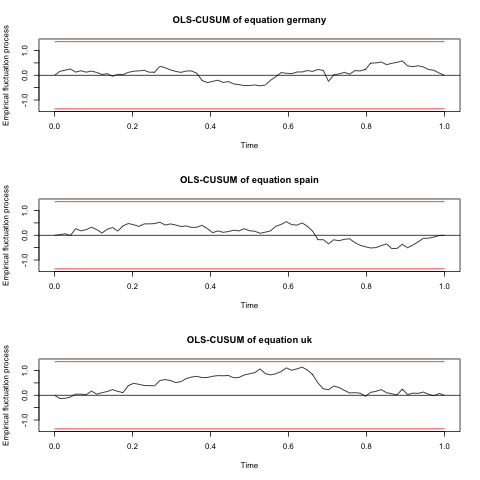

In [423]:
%%R
plot(stability(m1, type = "OLS-CUSUM"))

In [424]:
%%R
summary(m1)


VAR Estimation Results:
Endogenous variables: germany, spain, uk 
Deterministic variables: const 
Sample size: 74 
Log Likelihood: 927.855 
Roots of the characteristic polynomial:
0.8487 0.8487 0.8356 0.8356 0.5354 0.5354 0.5093 0.4858 0.4858
Call:
VAR(y = endog, p = lags)


Estimation results for equation germany: 
germany = germany.l1 + spain.l1 + uk.l1 + germany.l2 + spain.l2 + uk.l2 + germany.l3 + spain.l3 + uk.l3 + const 

            Estimate Std. Error t value Pr(>|t|)   
germany.l1  0.044196   0.123036   0.359  0.72062   
spain.l1    0.988420   0.327615   3.017  0.00366 **
uk.l1       0.455034   0.224997   2.022  0.04732 * 
germany.l2  0.002901   0.124807   0.023  0.98153   
spain.l2    0.505234   0.349942   1.444  0.15368   
uk.l2       0.063410   0.245657   0.258  0.79714   
germany.l3  0.189053   0.123944   1.525  0.13211   
spain.l3    0.345234   0.320470   1.077  0.28540   
uk.l3      -0.252272   0.217730  -1.159  0.25091   
const       0.001299   0.001312   0.990  0.3258

## ESTIMAR EL MODELO VAR CON D08

_Es posible que encontremos algún problema, por ejemplo, es posible que sea necesario incorporar una __variable ficticia__ que dé cuenta de la __crisis del precio del petróleo__ ocurrida en los años 70; a esta nueva variable la podemos llamar __D74__ y tomará valor 1 durante los cuatro trimestres de 1974 y valor 0 el resto. _

Dado que la crisis del petróleo no entra en el período, y el objetivo es capturar un comportamiento atípico, vamos a introducir una variable ficticia que recoja el efecto de la crisis actual, que llamaremos D08 que tomará valor 1 entre 2008-2010.

In [425]:
dummy = data.copy()
dummy['d08'] = 0
dummy.loc['2008':'2011', 'd08'] = 1
dummy.loc['2007':'2009']

,germany,spain,uk,d08
TIME,,,,
2007-01-01,0.004418,0.000760,0.009613,0
2007-04-01,0.007088,-0.002108,0.006021,0
2007-07-01,0.008322,-0.000032,0.007611,0
2007-10-01,0.003250,0.000552,0.007682,0
2008-01-01,0.008446,-0.004071,0.002491,1
2008-04-01,-0.002636,-0.003988,-0.005582,1
2008-07-01,-0.003722,-0.008096,-0.016966,1
2008-10-01,-0.019822,-0.002617,-0.022787,1
2009-01-01,-0.045566,-0.005934,-0.015818,1


_Incorporamos esta nueva variable explicativa a nuestro modelo, le indicamos el periodo de estimación, el número de retardos y para ver si resulta __conjuntamente significativa o no__ debemos ir al menú de contraste de hipótesis del VAR y seleccionar la opción que nos hace un contraste sobre la __exogeneidad de las variables__. Tras indicarle que queremos analizar la exogeneidad de D74 nos calculará un contraste __LR de la razón de verosimilitudes__, si el valor del p-valor de este contraste es menor que 0,05, aceptamos que mantenemos dicha variable al nivel de significación del 5%. __Comprobar cómo cambian los resultados de las tres ecuaciones__ estimadas del VAR con esta nueva variable y decidir con base en esos resultados si la mantenemos o no._

In [426]:
exog = dummy.d08

## ESTIMAR EL NÚMERO DE RETARDOS

In [427]:
%%R -i endog -i exog

endog = ts(endog, start = c(1995, 3), end = c(2014,3), frequency = 4)
exog = ts(exog, start = c(1995, 3), end = c(2014,3), frequency = 4)

print(VARselect(y = endog, lag.max = 12, exogen = exog, type = 'none')$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
    10      3      1      4 


In [428]:
%%R -i lags
m2 <- VAR(y = endog, p = lags, exogen = exog)

In [429]:
%%R
lrtest(m1, m2)

Likelihood ratio test

Model 1: VAR(y = endog, p = lags)
Model 2: VAR(y = endog, p = lags, exogen = exog)
  #Df LogLik Df  Chisq Pr(>Chisq)    
1  30 927.86                         
2  33 940.08  3 24.445  2.017e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


$H_0$: Modelo 1 (Restringido)

$H_a$: Modelo 2 (Con Ficticia)

El contraste LR nos da evidencia en contra de la hipótesis alternativa (variable ficticia no significativa), por tanto, rechazamos el modelo 1 sin ficticia y trabajaremos en adelante con el modelo 2.

In [430]:
%%R
arch(m2)


	ARCH (multivariate)

data:  Residuals of VAR object x
Chi-squared = 185.8, df = 180, p-value = 0.3678



$H_0$: Homocedasticidad

In [441]:
%%R
normality.test(m2)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object m2
Chi-squared = 38.076, df = 6, p-value = 1.086e-06


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object m2
Chi-squared = 4.5569, df = 3, p-value = 0.2073


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object m2
Chi-squared = 33.519, df = 3, p-value = 2.503e-07




$H_0$: La muestra proviene de una distribución normal


In [432]:
%%R
serial(m2, lags.pt = 16, type = 'BG')


	Breusch-Godfrey LM test

data:  Residuals of VAR object x
Chi-squared = 69.606, df = 45, p-value = 0.01076



$H_0$: No Autocorrelación

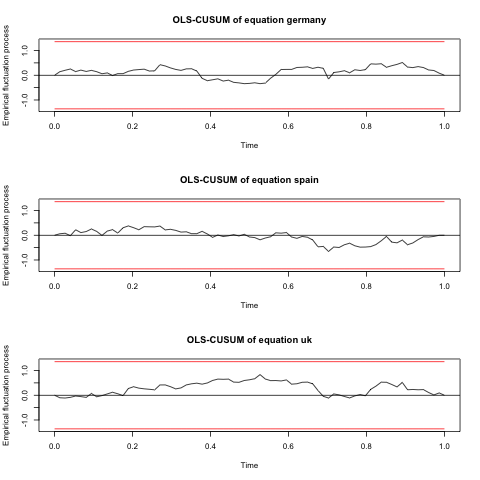

In [433]:
%%R
plot(stability(m2, type = "OLS-CUSUM"))

$H_0$: Estabilidad

<div style="font-family:serif;">
<div style="font-size:300%;">
<h1 style="text-align:center;">APARTADO B
</h1></div></div>

# b
Una vez determinado el modelo más adecuado, realizaremos __predicciones dinámicas__ para cada una de las variables endógenas. Para ello, tras indicarle que deje los últimos 20 valores para representar antes del periodo de predicción. Gretl nos ofrecerá una tabla con los valores reales y predichos, los errores y algunas medidas para evaluar y comparar las predicciones. La mejor __medida para comparar__ suele ser el __“porcentaje de error absoluto medio” (EAPM)__, con el que podemos comparar el error medio que comete cada una de las tres ecuaciones.

[⬆Caso2.3](#Caso-2.3-PRESENTAR)	[⬆a](#a)		[⬆b](#b)		[⬆c](#c)		

In [440]:
%%R
endog[1:len]
predict(m2, n.ahead = 20, ci = 0.95)


Error in predict.varest(m2, n.ahead = 20, ci = 0.95, dummy = exog) : 
No matrix for dumvar supplied, but object varest contains exogenous variables.


/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in predict.varest(m2, n.ahead = 20, ci = 0.95, dummy = exog) : 
No matrix for dumvar supplied, but object varest contains exogenous variables.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


<div style="font-family:serif;">
<div style="font-size:200%;">
<h1 style="text-align:center;">APARTADO C
</h1></div></div>

# c
Por último, realizaremos un estudio __“impulso-respuesta”__ con el VAR estimado, esto es, _cómo responden las variables endógenas ante un shock en alguna de ellas_; para ello se __descompone la varianza de los errores__ de predicción de las variables a lo largo de diferentes periodos. Una vez que tenemos modelo VAR con las variables que hayamos seleccionado, iremos a la opción __Gráficos-Respuestas al impulso (todas)__ y nos dibujará los efectos impulso-respuesta para un shock de cada variable sobre las demás.

Algo a tener en cuenta es que cuando se calculan los impulso-respuesta ortogonalizados se “normalizan” respecto de la primera variable que seleccionemos, la cual debe ser la que pensemos ejerce mayor influencia sobre las demás, es decir, tenemos que ordenarlas de mayor a menor exogeneidad según creamos. ¿Qué país produce mayores respuestas de los demás ante un shock inicial?

[⬆Caso2.3](#Caso-2.3-PRESENTAR)	[⬆a](#a)		[⬆b](#b)		[⬆c](#c)		